In [1]:
import qgrid
import numpy as np
import pandas as pd
from scipy.optimize import bisect
from scipy.constants import g, pi
from math import sqrt, cos, tanh
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.ticker as ticker
# costants

kn_ms = 1000/1852



# Диаграмма Ремеза




In [2]:


def wave_convert(height, inp_type = '1_3', out_type = '3p'):
    """ Function convert height of the waves in different systems
        height - input height
        inp_type - identifier of input system:
        out_type - identifier of input system
          identifiers:
            '3p' - 3% height (default)
            '1_3' - 13.5% height (default)
            'mean' - average height
            reference [1] (1.1) (page 18)
    """
    coef_matrice = {'3p':{'1_3':1/1.33, 'mean': 1/2.11},
                    '1_3':{'3p':1.33, 'mean': 1.33/2.11 },
                    'mean':{'3p':2.11, '1_3':2.11/1.33}}
    return    height*coef_matrice[inp_type][out_type]

## Параметры волнения

### Параметры регулярного волнения 

Длина волны: 

$$\lambda=\frac{g}{2\pi}\tau^2=\frac{2\pi}{g}c^2$$ , (1)


$$\tau=\sqrt{\frac{2\pi\lambda}{g}}=\frac{2\pi}{g}c$$  , (2)

$$c=\frac{\lambda}{\tau}=\sqrt{\frac{g\lambda}{2\pi}}=\frac{g}{2pi}\tau$$ , (3)

, где

$\tau$- период волны, с; $\lambda$ - длина волны, м; c - скорость волны, м/с; g - ускорение свободного падения
 
 [2] : формулы 1-3 стр 7

## Расчетные параметры волнения
Если в параметрах волнения присутствует только высота волны, то период волны можно оценить по формуле:

$$\tau=\beta3.1\sqrt{h_3%}$$ , (4)

где $\beta$ - коэффициент развитости волнения изменяется от 0.7 для развивающегося волнения до 1.5 для зыби
[1] (1.3) (page 19)

либо по формуле
$$\tau=\frac{18.7u}{g}\bigg(\frac{gh_{ср}}{u^2}\bigg)^{3/5}$$ , (5)

; где:
$h_ср$ - средняя высота волны, u - скорость истинного ветра, g - ускорение свободного падения


* Однако эти зависимости не надежны и лучше брать прогнозное или фактическое значение периода!!

In [3]:
# Функции если понадобятся
def wave_period_h3p(height_3p, method = 'lipis',  beta = 1, tws = 0):
    """ Function calculate average wave period
        method - lipis
        reference [1] (1.3) (page 19)
        method kozir 
        reference [2] (9) (page 18)
          
    """
    if method == 'lipis':
        period = beta*3.1*sqrt((height_3p))
    elif method == 'kozir':
        period = 18.7*(g*wave_convert(height_3p,'1_3','mean')/tws**2)**(3/5)/(g/tws)
    else:
        period = None
        
    return period

#### Для условий ограниченной глубины существуют следующие соотношения для скорости волны ее длины и периода

$$c=\sqrt{\frac{g\lambda}{2\pi}th\frac{2\pi H}{\lambda}}$$ , (6)

и
$$\tau=\sqrt{\frac{2\pi\lambda}{g}cth\frac{2\pi H}{\lambda}}$$, (7)

где
H - глубина

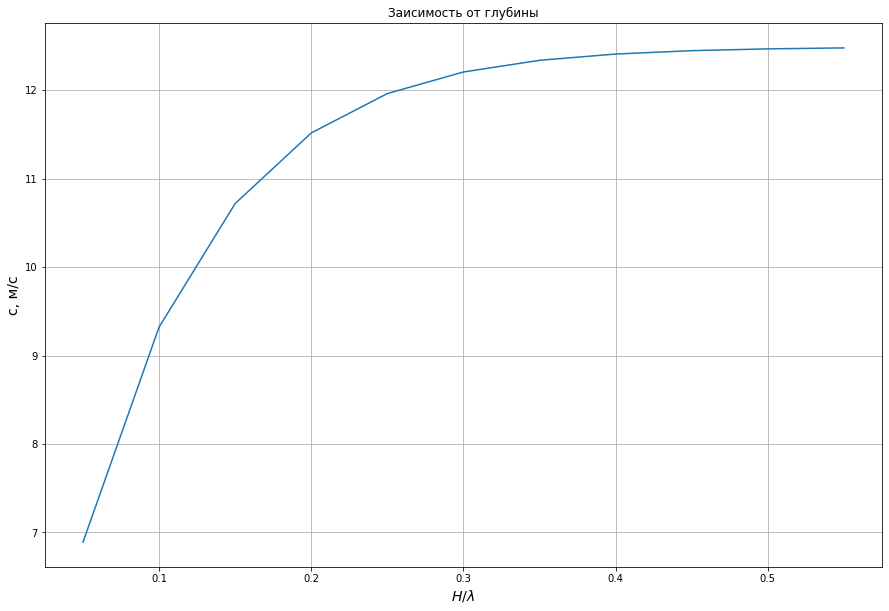

In [4]:
l_wave = 100
H = 20
arr_v=[]
arr_h=[]
for H in range(5,60,5):
    v_wave = sqrt(g*l_wave/(2*pi)*tanh(2*pi*H/l_wave))
    tau_wave = sqrt(2*pi*l_wave/g*1/(tanh(2*pi*H/l_wave)))
    arr_h.append(H/l_wave)
    arr_v.append(v_wave)
    # print('скорость - ', v_wave)
    # print('период - ', tau_wave)
    # print('скорость * период- ', v_wave*tau_wave)

plt.figure(figsize=[15,10])
plt.plot(arr_h,arr_v);
plt.grid()
plt.title('Заисимость от глубины')    
plt.xlabel(r'$ H/\lambda$', fontsize=14 )
plt.ylabel('c, м/с' , fontsize=14);

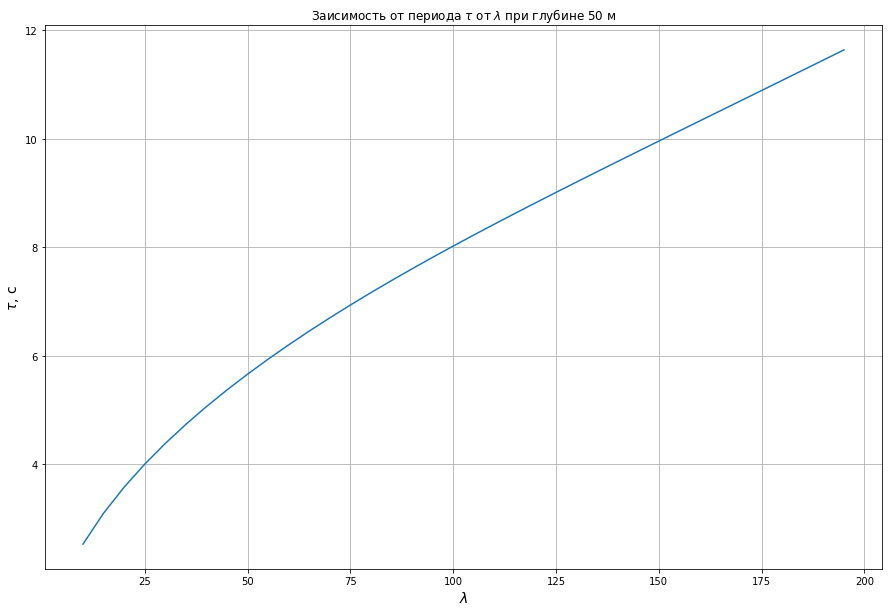

In [5]:
l_wave = 100
H = 50
arr_v=[]
arr_h=[]
for l_wave in range(10,200,5):
    v_wave = sqrt(g*l_wave/(2*pi)*tanh(2*pi*H/l_wave))
    tau_wave = sqrt(2*pi*l_wave/g*(1/(tanh(2*pi*H/l_wave))))
    arr_h.append(l_wave)
    arr_v.append(tau_wave)
    # print('скорость - ', v_wave)
    # print('период - ', tau_wave)
    # print('скорость * период- ', v_wave*tau_wave)

plt.figure(figsize=[15,10])
plt.plot(arr_h,arr_v);
plt.grid()
plt.title(r'Заисимость от периода $\tau$ от $\lambda$'+f' при глубине {H} м')    
plt.xlabel(r'$ \lambda$', fontsize=14 )
plt.ylabel(r'$\tau$, с' , fontsize=14);




Поскольку не знаю как вынуть длину волны из под гиперболического тангенса для нахождения длины волны по заданному 
периоду решим уравнение (7) численно  

In [6]:
# Численное решение для определения длины волны по заданному периоду
tau_wave = 8
def slv(l_wave,tau,H):
    '''function for founding L wave by period'''
    # H = 50
    # tau = 8
    return sqrt(2*pi*l_wave/g*(1/(tanh(2*pi*H/l_wave))))-tau

bisect(slv,2,300, (tau_wave, H));

Возьмем для примера:

H = 50 м

$\tau =$8 сек

Тогда 

In [7]:
H = 50
tau_wave = 8
# l_wave = bisect(slv,2,300, (tau_wave, H))
# v_wave = sqrt(g*l_wave/(2*pi)*tanh(2*pi*H/l_wave))

In [8]:
# Определим функции для расчета длины и скорости волны через период и периода через длину волны

def wave_length(tau, H =None ):
    if H is None:
        H = 3000
    return bisect(slv,2,400, (tau, H))

def wave_speed(tau, H = None,):
    
    """ wave speed in m/s"""
    if H is None:
        H = 3000
    l_wave = wave_length(tau, H)
    c = sqrt(g*l_wave/(2*pi)*tanh(2*pi*H/l_wave))
    return c
def wave_speed_l(l_wave, H = None,):
    
    """ wave speed in m/s"""
    if H is None:
        H = 3000
    c = sqrt(g*l_wave/(2*pi)*tanh(2*pi*H/l_wave))
    return c
def wave_tau(l_wave, H):
    return sqrt(2*pi*l_wave/g*1/(tanh(2*pi*H/l_wave)))

# print(wave_tau(99.53, H))
print('λ = ',wave_length(tau_wave,H), 'м')
print('c = ',wave_speed(tau_wave,H), 'м/с')












λ =  99.528242337481 м
c =  12.441030292185092 м/с


## Параметры судна
Для теста рассмотрим судно из [3]

Основные размерения:

In [9]:
# Длина по ВЛ
lwl = 275
# Ширина max
b_max = 44
# Осадка
d = 9.2
# Метацентрическая высота
h = 10.4


## Расчетные данные по судну



Оптимальный вариант - получить периоды собственных колебаний судна из надежных источников. 
Но если их нет, то возможен приближенный расчет.

Если известны только основные размерения возможно применение капитанских формул [3]:

- период вертикальной качки 

     $\tau_\varsigma=2.5\sqrt{d}$
     
- период килевой качки

    $\tau_\psi=2.4\sqrt{d}$
    
- период бортовой качки
    
    $\tau_\theta=2CB\sqrt{d}$
    
    где d- осадка судна, B - ширина судна, С - инерционный коэффициент равный:
    $$C=0.373 +\frac{0.023B}{d}-\frac{0.043LWL}{100}$$
     
тогда в нашем случае:

In [10]:
# Период собственных вертикальных колебаний
t_dzeta = 2.5 * sqrt(d)
# Период собственных продольных колебаний 
t_fi = 2.4*sqrt(d)

# Инерционный коэфиициент
c = 0.373 + 0.023*b_max/d - 0.043*lwl/100
# Период собственных пеперечных колебаний 
t_teta = 2*c*b_max/sqrt(h) 


In [11]:
print('Инерционный коэфиициент', c)
print('Период бортовых колебаний',t_teta)
print('Период продольных колебаний', t_fi)
print('Период вертикальных колебаний',t_dzeta)

Инерционный коэфиициент 0.36475
Период бортовых колебаний 9.953167277111032
Период продольных колебаний 7.279560426289487
Период вертикальных колебаний 7.58287544405155


При известном поперечном моменте инерции период бортовой качки можно вычислить по формулам :
$$\tau_\theta=2\pi\sqrt{\frac{I_x}{Dh}}$$

где
$I_x$ - поперечный момент инерции судна.
Существуют 2 импирических формулы для его оценки

$$I_x=\frac{D}{g}*\bigg(\frac{B^2+4z_g^2}{11}\bigg)$$

либо

$$I_x=\frac{D}{g}*\bigg(\frac{B^2\delta}{10.3\alpha^2}+\frac{H_б^2}{11}\bigg)$$

[4] стр 210





## На данный момент мы имеем все иходные данные для расчета:
*Данные по волнению:*

Длина волны - $\lambda$

Период волны - $\tau$

*Данные по судну*

Длина по ВЛ  - LWL

Период собственных поперечных колебаний - $\tau_\theta$

Период собственных продольных колебаний - $\tau_\psi$

Период собственных вертикальных колебаний - $\tau_\varsigma$

Диаграмма Ремеза проверяет два опасных случая:

1. Попадание в резонанс волнового воздействия и собственных частот колебаний. Опасным считается случай когда 
отношение кажущегося периода волнения и периода собственных колебаний составляет между 0.7 и 1.3
1. Уменьшение остойчивости на попутном волнении при близости проекции скорости судна на направление волны к 
скорости волны

Кажущийся период волны вычисляется по формуле:

$\tau_a=\frac{\lambda}{c+Vcosq} $

где
с - скорость волны, м/с; V - скорость судна, м/с; q - угол к волне

In [12]:
#Определим функцию для расчета кажущегося периода через период волны
def tau_app(tau, H, V, q):
    l_wave = wave_length(tau, H)
    # print(l_wave)
    c = wave_speed(tau, H)
    # print(c)
    return abs(l_wave/(c+V*cos(q)))

In [13]:
# print(wave_length(8, 100))
# print(tau_app(8, 100, 10, 90))

In [20]:
print('Инерционный коэфиициент', c)
print('Период бортовых колебаний',t_teta)
print('Период продольных колебаний', t_fi)
print('Период вертикальных колебаний',t_dzeta)

#Для расчета примем диапазон скоростей от 8 до 20 узл
#период волны 8 с
# taus_app_0 = np.array([])
# taus_app_1 = np.array([])
H = 800
data = []
for t_wave in np.arange(6,18,2):
    for V in np.arange(8,22,2)*kn_ms:
        for wave_angle in np.linspace(0,180,37):
            t_app = tau_app(t_wave, H, V, wave_angle/180*pi)
            r_heel = t_app/t_teta
            r_pith = t_app/t_fi
            r_ver = t_app/t_dzeta
            data.append({'tau_wave':t_wave,'angle':wave_angle,'Vs':V/kn_ms, 'r_heel': r_heel, 'r_pith': r_pith,
            'r_vert': r_ver})
df = pd.DataFrame(data)

Инерционный коэфиициент 0.36475
Период бортовых колебаний 9.953167277111032
Период продольных колебаний 7.279560426289487
Период вертикальных колебаний 7.58287544405155


In [21]:
# qgrid_widget = qgrid.show_grid(df, show_toolbar=True)
# qgrid_widget

На следующих графиках изображено отношение кажущегося периода волны к 
собственному периоду бортовых колебаний $\tau_a/\tau_\theta$ для различных скоростей судна и длин волн.
Синим кольцом помечены опасные сочетания по условию резонанса



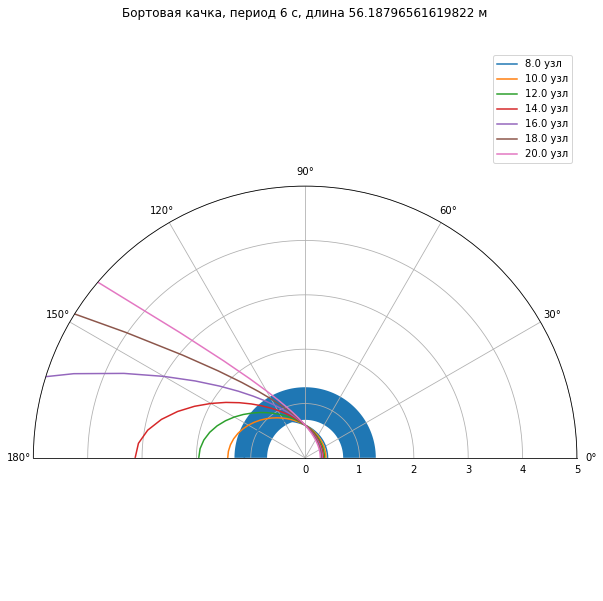

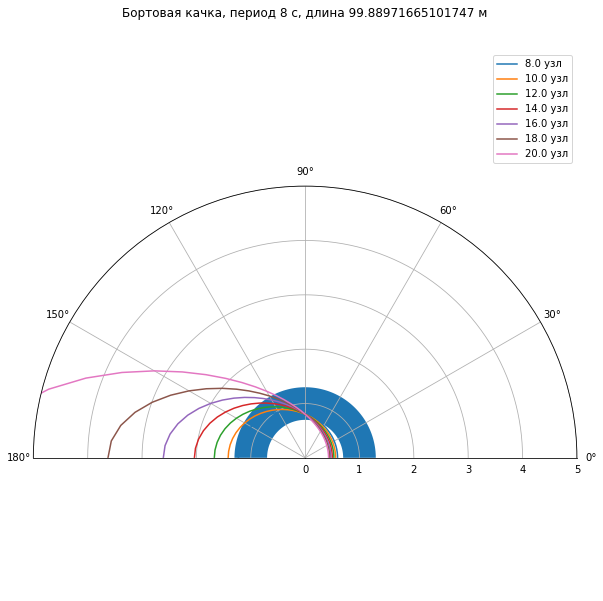

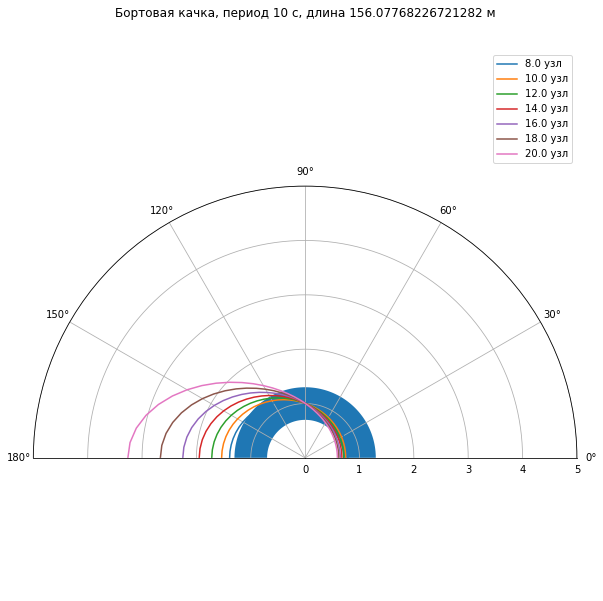

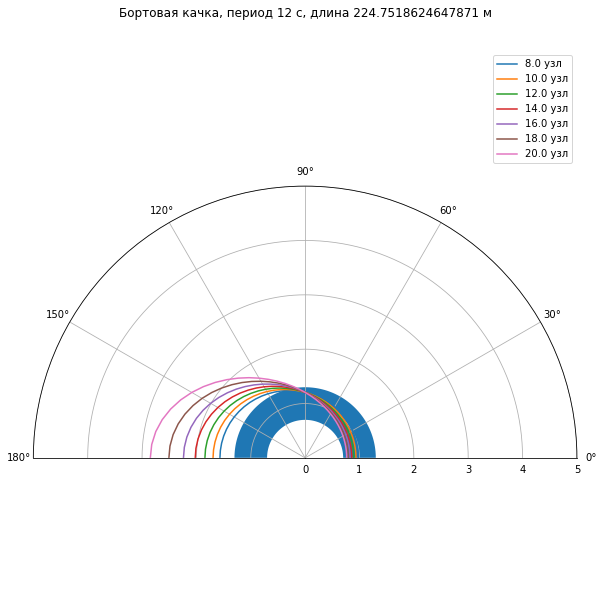

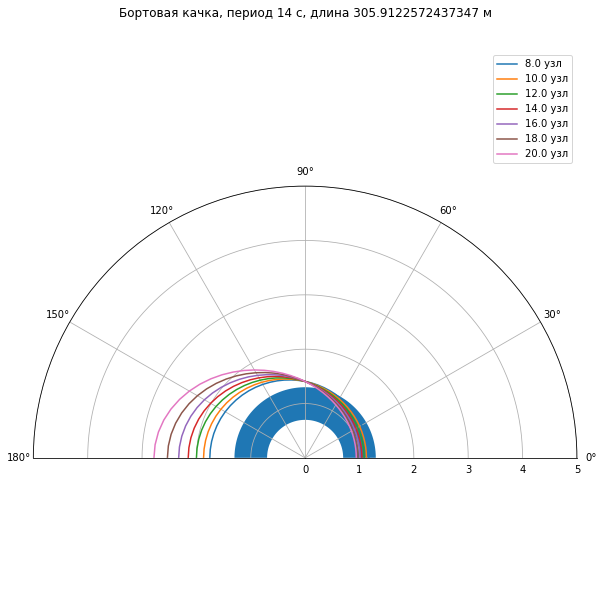

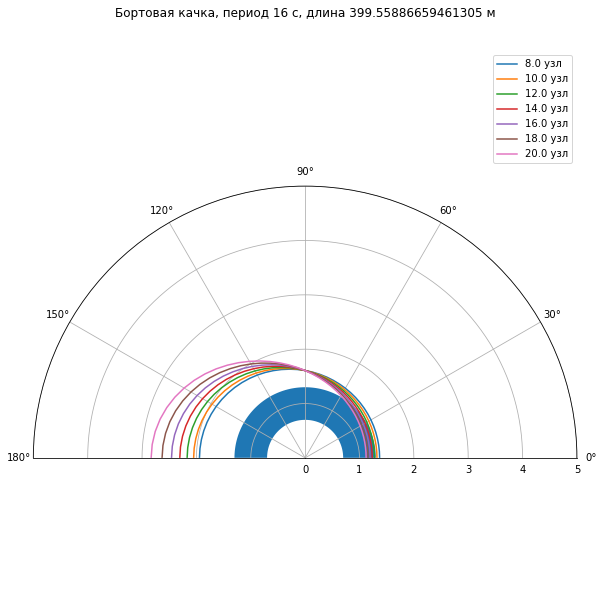

In [26]:
# print(taus_app_0)

for  tau_w in df['tau_wave'].unique():
    l_wave = wave_length(tau_w,H)
    plt.figure(figsize=[10,13])
    ax = plt.subplot(111, projection = 'polar')
    ax.set_thetamax(180)
    ax.set_title(f'Бортовая качка, период {tau_w} c, длина {l_wave} м'); 
    ax.set_axis_on()
    ax.add_patch(patches.Rectangle((0, 0.7), width=pi, height=0.6))
    ax.bar(0, 1).remove()
    ax.set_ylim(0,5)
    for  V in df['Vs'].unique():
        df_filter = df[(df['tau_wave'] == tau_w) & (df['Vs']==V)]
        # ax.set_xlim(0,pi)

        ax.plot(df_filter['angle']/180*pi, df_filter['r_heel'], label=f'{V} узл')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(30/180*pi))
        # ax.axvline(40/180*pi, linestyle='--')
        # ax.set_rlabel_position(10.5)
        # ax.set_label('')
    ax.legend(loc='best')




## Литература
1. В.Б. Липис, Ю.В. Ремез Безопасные режимы штормового плавания судов
1. Л.А. Козырь, Л.Р. Аксютин Управление судами в шторм
1. А.А. Ершов, С.В. Сольнов, А.М. Бояринов Диаграмма для определения опасных областей при движении судна в штормовом море
1. Б.В. Бекенский Практические расчеты мореходных качеств судна
1. И.К. Бородай, Ю.А. Нецветаев Мореходность судов
1. Правила классификации и постройки морских судов 2018 // Российский Морской Регистр Судо-
ходства Ч. IV. Остойчивость.